In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

data = pd.read_csv('UK.csv')
data_long=132
data = np.array(np.log(data['drivers']))
data_sm = sm.tsa.seasonal_decompose(np.array(data), freq=12)
Data = data_sm.trend[6:-6]+data_sm.resid[6:-6]
Data = Data[:133]

In [14]:
Data.shape

(133,)

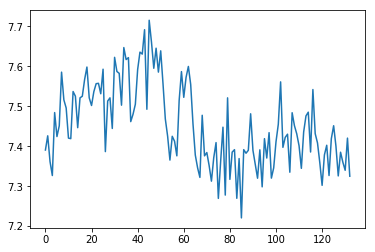

In [15]:
plt.plot(Data)
plt.show()

### 線形ガウス状態空間モデル
$
\begin{align}
x_{t}&=f_{t}(x_{t-1},\upsilon_{t})=
\begin{pmatrix}
x_{t,1}\\
x_{t,2}
\end{pmatrix}
=
\begin{pmatrix}
1&1\\
0&1
\end{pmatrix}
\begin{pmatrix}
x_{t-1,1}\\
x_{t-1,2}
\end{pmatrix}+
\begin{pmatrix}
\upsilon_{t-1,1}\\
\upsilon_{t-1,2}
\end{pmatrix}\\
y_{t}&=h_{t}(x_{t},\omega_{t})=Fx_{t}+\omega_{t}=\begin{pmatrix}1&1\end{pmatrix}x_{t}+\omega_{t}
\end{align}
$

In [16]:
class ParticleFilter:
    def __init__(self,y,number_of_particles,upsilon2,omega2):
        self.y=y
        self.length_of_time=y.shape[0]
        self.number_of_particles=number_of_particles
        self.upsilon2=upsilon2
        self.omega2=omega2
        self.filtered_value = []
        self.Trans=np.array([[1,1],[0,1]])# local trend level model
        # self.Trans=np.array([[1,0],[0,0]])# local lebel model
        
    def init_particle(self):
        # x(i)_0|0
        particles = []
        predicts = []
        init_level=np.random.normal(7,1,self.number_of_particles)
        init_trend=np.random.normal(0,0.1,self.number_of_particles)
        init=np.array([init_level,init_trend]).T
        particles.append(init)
        predicts.append(init)
        return({'particles':particles,'predicts':predicts})
        
    def get_likelihood(self,ensemble,t):
        #正規分布を仮定
        likelihoodes = np.zeros(self.number_of_particles)
        for n in range(self.number_of_particles):    
            likelihoodes[n] = (1/np.sqrt(2*np.pi*self.omega2))*np.exp(-(self.y[t]-np.dot(np.array([1,1]).reshape(1,2),ensemble[t][n].reshape(2,1)))**2/2*self.omega2)
        return(likelihoodes)
    
    def one_predict(self,ensemble,t):
        Sigma = np.random.multivariate_normal([0,0],[[self.upsilon2[0],0],[0,self.upsilon2[1]]],self.number_of_particles)
        one_predicts = np.dot(self.Trans,ensemble[t].T)+Sigma.T
        return(one_predicts.T)
            
    def filtering(self,ensemble,t):
        # x(i)_t|t
        likelihood=self.get_likelihood(ensemble,t)
        beta=likelihood/np.sum(likelihood) #尤度の比率
        filtering_value=np.sum(beta.reshape(self.number_of_particles,1)*ensemble[t],axis=0)
        return({'beta':beta,'filtering_value':filtering_value})
    
    def resumpling(self,ensemble,weight):
        sample0=np.random.choice(ensemble[:,0],p=weight,size=self.number_of_particles)
        sample1=np.random.choice(ensemble[:,1],p=weight,size=self.number_of_particles)
        sample = np.array([sample0,sample1])
        return(sample.T)
    
    def simulate(self):
        particles=self.init_particle()['particles']
        predicts=self.init_particle()['predicts']
        filtered_value=[]
        filtered_value.append(np.sum(particles[0],axis=0)/self.number_of_particles)
        for t in np.arange(1,self.length_of_time):
            # print("\r calculating... t={}".format(t), end="")
            #一期先予測
            predicts.append(self.one_predict(particles,t-1))
            #フィルタリング
            filtered=self.filtering(predicts,t)
            filtered_value.append(filtered['filtering_value'])
            resumple=self.resumpling(predicts[t],filtered['beta'])
            particles.append(resumple)
        return({'particles':np.array(particles),'predicts':np.array(predicts),'filtered_value':np.array(filtered_value)})
    
    def forecast(self,result,time=10):
        Forecasts_ens = []
        Forecasts_mean = []
        ensemble= result['particles'][-1]
        for t in range(time):
            if t == 0:
                Sigma = np.random.multivariate_normal([0,0],[[self.upsilon2[0],0],[0,self.upsilon2[1]]],self.number_of_particles)
                Forecasts_ens.append(np.dot(ensemble.reshape(self.number_of_particles,2),self.Trans.T)+Sigma)
                Forecasts_mean.append(np.mean(Forecasts_ens[t],axis = 0))
            else:
                Sigma = np.random.multivariate_normal([0,0],[[self.upsilon2[0],0],[0,self.upsilon2[1]]],self.number_of_particles)
                Forecasts_ens.append(np.dot(Forecasts_ens[t-1],self.Trans.T)+Sigma)
                Forecasts_mean.append(np.mean(Forecasts_ens[t],axis = 0))
        return({'Forecasts_ens':np.array(Forecasts_ens),'Forecasts_mean':np.array(Forecasts_mean)})

In [17]:
model = ParticleFilter(Data,10000,np.array([1,0.0]),7)

In [81]:
result = model.simulate()

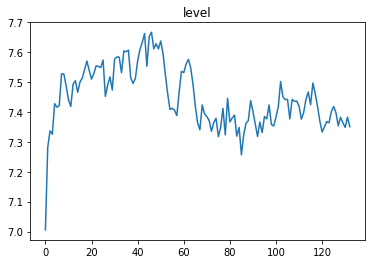

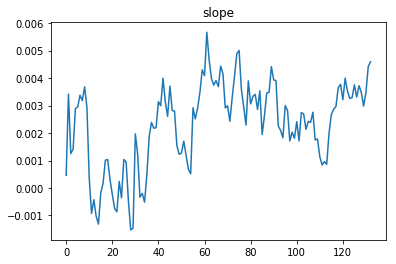

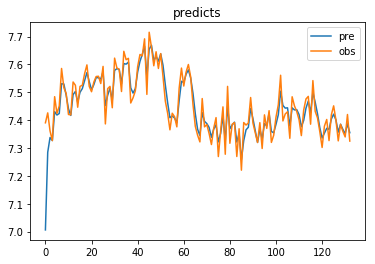

In [82]:
plt.plot(result['filtered_value'][:,0])
plt.title('level')
plt.show()
plt.plot(result['filtered_value'][:,1])
plt.title('slope')
#plt.plot(data)
plt.show()
plt.plot(result['filtered_value'][:,0]+result['filtered_value'][:,1],label='pre')
plt.plot(Data,label='obs')
plt.title("predicts")
plt.legend()
plt.show()

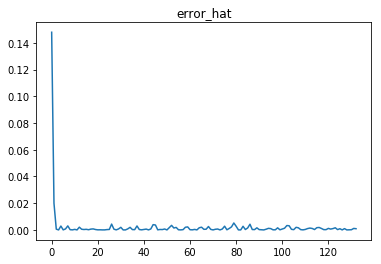

In [83]:
plt.plot((Data-result['filtered_value'][:,0]-result['filtered_value'][:,1])**2)
plt.title('error_hat')
plt.show()

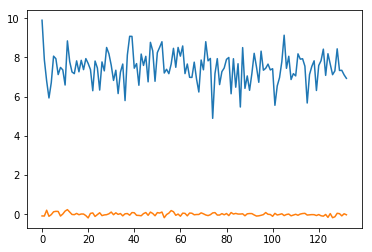

In [84]:
plt.plot(np.array(result['particles'][:,1]))
plt.show()

In [85]:
np.array(result['particles']).shape

(133, 10000, 2)

In [91]:
forecast = pd.DataFrame(model.forecast(result,50)['Forecasts_mean'])
forecast.index = forecast.index+data_long

In [92]:
plt.plot(result['filtered_value'][:,0]+result['filtered_value'][:,1])
plt.title('level')

Text(0.5,1,'level')

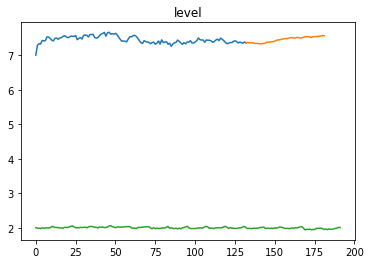

In [93]:
plt.plot(forecast.loc[:,0]+forecast.loc[:,1])
plt.plot(np.log(data))
plt.show()

In [94]:
def rmse(predic,test):
    mse = np.sum(((predic-test)**2))/predic.shape[0]
    RMSE = np.sqrt(mse)
    return(RMSE)

In [99]:
forecast = model.forecast(result,94)['Forecasts_mean']
rmse(np.array(data[-60:-1]),(forecast[:,0]+forecast[:,1]).reshape(94,1))

4.3747854548660072

In [100]:
num = 0
for i in np.arange(1,10,1):
    for j in np.arange(1,10,1):
        model = ParticleFilter(Data,10000,np.array([i,0.0]),j)
        result = model.simulate()
        forecast = model.forecast(result,94)['Forecasts_mean']
        Err = rmse(np.array(data.tail(94)),(forecast[:,0]+forecast[:,1]).reshape(94,1))
        if i==1 and j==1:
            err = Err
            print('\n i:{},j:{},rmse:{}'.format(i,j,err))
        if err>Err:
            err = Err
            print('\ni:{},j:{},rmse:{}'.format(i,j,err))
        num = num+1
        print("\r calculating... num={}".format(num), end="")

KeyboardInterrupt: 

In [ ]:
plt.plot(result['filtered_value'][:,1])
for n in range(len(Data)):
    plt.scatter(np.zeros(result['particles'].shape[1])+n,result['particles'][n][:,1],color='red',s=1,alpha=0.1)
plt.title('slope')
#plt.ylim(0.02,0.026)
plt.show()

In [ ]:
plt.plot(result['filtered_value'][:,0])
for n in range(len(Data)):
    plt.scatter(np.zeros(result['particles'].shape[1])+n,result['particles'][n][:,0],color='red',s=1,alpha=0.1)
plt.title('trend')
plt.show()